In [1]:
cd /content

/content


In [2]:
!ls

sample_data


In [3]:
!git clone https://github.com/shlvd/cs231n_stanford_2019.git

Cloning into 'cs231n_stanford_2019'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 279 (delta 13), reused 1 (delta 1), pack-reused 245
Receiving objects: 100% (279/279), 2.54 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [4]:
%cd cs231n_stanford_2019/assignment2

/content/cs231n_stanford_2019/assignment2


In [5]:
%cd cs231n/datasets/
!ls

/content/cs231n_stanford_2019/assignment2/cs231n/datasets
get_datasets.sh


In [6]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2019-12-29 13:28:29--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  91.7MB/s    in 1.8s    

2019-12-29 13:28:31 (91.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [14]:
%cd ../
!ls

/content/cs231n_stanford_2019/assignment2
BatchNormalization.ipynb     FullyConnectedNets_shlvd.ipynb
collectSubmission.sh	     notebook_images
ConvolutionalNetworks.ipynb  PyTorch.ipynb
cs231n			     requirements.txt
Dropout.ipynb		     start_ipython_osx.sh
frameworkpython		     TensorFlow.ipynb
FullyConnectedNets.ipynb


In [12]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [56]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



In [57]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


In [58]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



In [59]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.878000; val_acc: 0.269000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.275000
(Epoch 10 / 25) train acc: 0.888000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.926000; val_acc: 0.278000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.302000
(Epoch 13 / 25) train acc: 0.964000; val_acc: 0.306000
(Epoch 14 / 25) train acc: 0.966000; val_acc: 0.309000
(Epoch 15 / 25) train acc: 0.976000; val_acc: 0.288000
(Epoch 16 / 25) train acc: 0.988000; val_acc: 0.301000
(Epoch 17 / 25) train acc: 0.988000; v

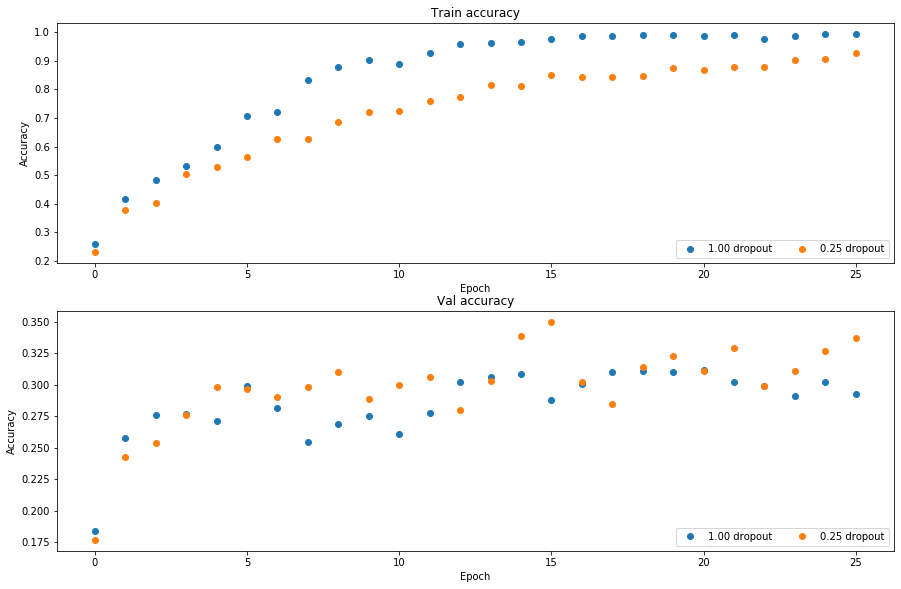

In [60]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()